In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import pathlib
import torchvision
from torch.optim.lr_scheduler import ExponentialLR
import torchvision.utils as vutils

import pytorch_lightning as pl

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from matplotlib.ticker import MaxNLocator

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import datetime
import time
import random
import os
import cv2

import sys

# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda:0

NVIDIA GeForce RTX 2080 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
class MyDataset(Dataset):
    def __init__(self, image_folder, transpose=True):
        self.image_folder = image_folder
        self.transpose = transpose
        
        # Create a list of labels and image file paths
        self.labels = []
        self.image_files = []
        for label in os.listdir(image_folder):
            label_folder = os.path.join(image_folder, label)
            if os.path.isdir(label_folder):
                for image_file in os.listdir(label_folder):
                    if image_file.endswith('.png'):
                        self.labels.append(label)
                        self.image_files.append(os.path.join(label_folder, image_file))
                        
        # Create a label encoder
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # Load the image
        image = cv2.imread(self.image_files[index])
        
        # Pre-process the image
        image = cv2.resize(image, (64, 64))
        image = image.astype(np.float32)
        image = image / 255.0
        
        # Transpose the image if necessary
        if self.transpose:
            image = np.transpose(image, (2, 0, 1))
            
        # Load the label
        label = self.labels[index]
        return image, label

In [3]:
df_train = MyDataset(image_folder="C:/Users/Lisa/Rezanur/Pytorch/MUL_UNI/img set 3/Tesla_Test/Train")
df_test = MyDataset(image_folder="C:/Users/Lisa/Rezanur/Pytorch/MUL_UNI/img set 3/Tesla_Test/Test")
df_val = MyDataset(image_folder="C:/Users/Lisa/Rezanur/Pytorch/MUL_UNI/img set 3/Tesla_Test/Val")

In [4]:
df_train[0][0].shape

(3, 64, 64)

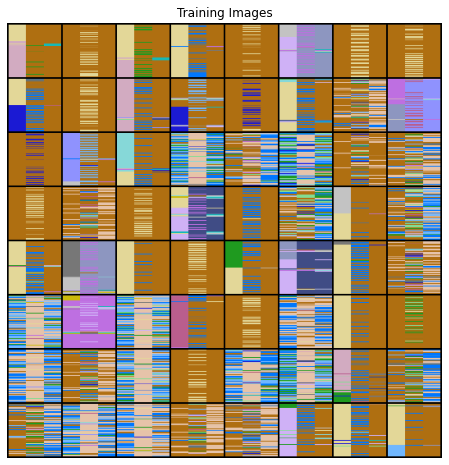

In [5]:
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
NUM_WORKERS = 0
PIN_MEMORY = False

train_loader = torch.utils.data.DataLoader(df_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
valid_loader = torch.utils.data.DataLoader(df_val, batch_size=VALID_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)



# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(0)

In [7]:
class VGG16_NET(nn.Module):
    def __init__(self):
        super(VGG16_NET, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc14 = nn.Linear(512 * 2 * 2, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        self.fc16 = nn.Linear(4096, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.maxpool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.maxpool(x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc14(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc15(x))
        x = F.dropout(x, 0.5)
        x = self.fc16(x)
        return x

In [8]:
# get some random training images
dataiter = iter(train_loader)
sets, labels = dataiter.next()
sets = sets.float()
labels = labels.type(torch.LongTensor)

print(sets[0].shape)
print(sets[0].ndim)

print(sets.shape)
print(sets.ndim)

torch.Size([3, 64, 64])
3
torch.Size([64, 3, 64, 64])
4


In [16]:
net = VGG16_NET()

In [17]:
# Load model and data in same device
model = net.to(device)
sets = sets.to(device)

In [18]:
# Label 1 data shape
output1 = model.conv1(sets)
output1.shape

torch.Size([64, 64, 64, 64])

In [19]:
# Label 1 data shape
output2 = model.conv2(output1)
output2.shape

torch.Size([64, 64, 64, 64])

In [20]:
# Label 1 data shape
output3 = model.maxpool(output2)
output3.shape

torch.Size([64, 64, 32, 32])

In [21]:
# Label 1 data shape
output4 = model.conv3(output3)
output4.shape

torch.Size([64, 128, 32, 32])

In [22]:
# Label 1 data shape
output5 = model.conv4(output4)
output5.shape

torch.Size([64, 128, 32, 32])

In [23]:
# Label 1 data shape
output6 = model.maxpool(output5)
output6.shape

torch.Size([64, 128, 16, 16])

In [24]:
# Label 1 data shape
output7 = model.conv5(output6)
output7.shape

torch.Size([64, 256, 16, 16])

In [25]:
# Label 1 data shape
output8 = model.conv6(output7)
output8.shape

torch.Size([64, 256, 16, 16])

In [26]:
# Label 1 data shape
output9 = model.conv7(output8)
output9.shape

torch.Size([64, 256, 16, 16])

In [27]:
# Label 1 data shape
output10 = model.maxpool(output9)
output10.shape

torch.Size([64, 256, 8, 8])

In [28]:
# Label 1 data shape
output11 = model.conv8(output10)
output11.shape

torch.Size([64, 512, 8, 8])

In [29]:
# Label 1 data shape
output12 = model.conv9(output11)
output12.shape

torch.Size([64, 512, 8, 8])

In [30]:
# Label 1 data shape
output13 = model.conv10(output12)
output13.shape

torch.Size([64, 512, 8, 8])

In [31]:
# Label 1 data shape
output14 = model.maxpool(output13)
output14.shape

torch.Size([64, 512, 4, 4])

In [32]:
# Label 1 data shape
output15 = model.conv11(output14)
output15.shape

torch.Size([64, 512, 4, 4])

In [33]:
# Label 1 data shape
output16 = model.conv12(output15)
output16.shape

torch.Size([64, 512, 4, 4])

In [34]:
# Label 1 data shape
output17 = model.conv13(output16)
output17.shape

torch.Size([64, 512, 4, 4])

In [35]:
# Label 1 data shape
output18 = model.maxpool(output17)
output18.shape

torch.Size([64, 512, 2, 2])

In [9]:
class EarlyStopping:
    def __init__(self, mode, path, patience=3, delta=0):
        if mode not in {'min', 'max'}:
            raise ValueError("Argument mode must be one of 'min' or 'max'.")
        if patience <= 0:
            raise ValueError("Argument patience must be a postive integer.")
        if delta < 0:
            raise ValueError("Argument delta must not be a negative number.")
            
        self.mode = mode
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = np.inf if mode == 'min' else -np.inf
        self.counter = 0
        
    def _is_improvement(self, val_score):
        """Return True iff val_score is better than self.best_score."""
        if self.mode == 'max' and val_score > self.best_score + self.delta:
            return True
        elif self.mode == 'min' and val_score < self.best_score - self.delta:
            return True
        return False
        
    def __call__(self, val_score, model):
        """Return True iff self.counter >= self.patience.
        """
        
        if self._is_improvement(val_score):
            self.best_score = val_score
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            print('Val loss improved. Saved model.')
            return False
        else:
            self.counter += 1
            print(f'Early stopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                print(f'Stopped early. Best val loss: {self.best_score:.4f}')
                return True

In [10]:
def train_one_epoch(model, train_loader, optimizer, device, criterion):
    """Train model for one epoch and return the mean train_loss."""
    model.train()
    running_loss_train = 0
    for inputs, labels in train_loader:
        labels = labels.type(torch.LongTensor)
        inputs = inputs.type(torch.cuda.FloatTensor)
        #labels = labels.type(torch.cuda.FloatTensor)
        inputs, labels = inputs.to(device=device), labels.to(device=device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
    train_loss = running_loss_train / len(train_loader.dataset)
    return train_loss

In [11]:
def validate(model, valid_loader, device, criterion):
    """Validate model and return the accuracy and mean loss."""
    model.eval()
    correct = 0
    running_loss_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            labels = labels.type(torch.LongTensor)
            inputs = inputs.type(torch.cuda.FloatTensor)
            #labels = labels.type(torch.cuda.FloatTensor)
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            pred = outputs.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            running_loss_val += loss.item()
    val_acc = correct / len(valid_loader.dataset)
    val_loss = running_loss_val / len(valid_loader.dataset)
    return val_acc, val_loss

In [12]:
def fit(model, train_loader, valid_loader, learning_rate, num_epochs):
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    es = EarlyStopping(mode='min', path='./VGG_Adam_T_Tesla.pth', patience=10)
    model = model.to(device)
    scheduler = ExponentialLR(optimizer, gamma=0.1)

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, criterion)
        val_acc, val_loss = validate(model, valid_loader, device, criterion)
        scheduler.step()
        print(f'Epoch {epoch:2}/{num_epochs}',
              f'train loss: {train_loss:.4f}',
              f'val loss: {val_loss:.4f}',
              f'val acc: {val_acc:.2%}',
              sep=' | '
             )
        if es(val_loss, model):
            break

In [13]:
model = VGG16_NET().to(device)
start = time.time()
fit(model, train_loader, valid_loader, learning_rate=LEARNING_RATE, num_epochs=NUM_EPOCHS)
print(f'Total training time: {time.time() - start}')
model.load_state_dict(torch.load('VGG_Adam_T_Tesla.pth'))

Epoch  1/50 | train loss: 2.3279 | val loss: 1.3280 | val acc: 38.67%
Val loss improved. Saved model.
Epoch  2/50 | train loss: 1.0149 | val loss: 0.4410 | val acc: 84.28%
Val loss improved. Saved model.
Epoch  3/50 | train loss: 0.1812 | val loss: 0.4345 | val acc: 86.87%
Val loss improved. Saved model.
Epoch  4/50 | train loss: 0.1552 | val loss: 0.4562 | val acc: 86.62%
Early stopping counter: 1/10
Epoch  5/50 | train loss: 0.1538 | val loss: 0.4575 | val acc: 86.79%
Early stopping counter: 2/10
Epoch  6/50 | train loss: 0.1546 | val loss: 0.4575 | val acc: 86.60%
Early stopping counter: 3/10
Epoch  7/50 | train loss: 0.1522 | val loss: 0.4596 | val acc: 86.76%
Early stopping counter: 4/10
Epoch  8/50 | train loss: 0.1545 | val loss: 0.4546 | val acc: 86.68%
Early stopping counter: 5/10
Epoch  9/50 | train loss: 0.1534 | val loss: 0.4552 | val acc: 86.59%
Early stopping counter: 6/10
Epoch 10/50 | train loss: 0.1530 | val loss: 0.4534 | val acc: 86.62%
Early stopping counter: 7/10
E

<All keys matched successfully>

In [15]:
# Load
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
NUM_WORKERS = 0
PIN_MEMORY = False

test_loader = torch.utils.data.DataLoader(df_test, batch_size=VALID_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

model = VGG16_NET()
model.load_state_dict(torch.load('C:/Users/Lisa/Rezanur/Pytorch/MUL_UNI/img set 3/Tesla_Test/VGG RGB_T_Tesla/VGG_Adam_T_Tesla.pth'))
model.eval()

VGG16_NET(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(3,

In [16]:
def get_prediction(model, dataloader):
    with torch.no_grad():
        model = model.to(device)
        model.eval()
        prediction = np.zeros(len(dataloader.dataset))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if device:
                images = images.type(torch.cuda.FloatTensor)
            prediction[k:k+len(images)] = np.argmax(model(images).data.cpu().numpy(), axis=1)
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return prediction, labels

In [17]:
pred = get_prediction(model, test_loader)
y_pred = pred[0]
y_test = pred[1]

In [18]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[1981   19    0    0]
 [ 440 3522   37    1]
 [   0    0 3036    0]
 [ 662   58    1  162]]


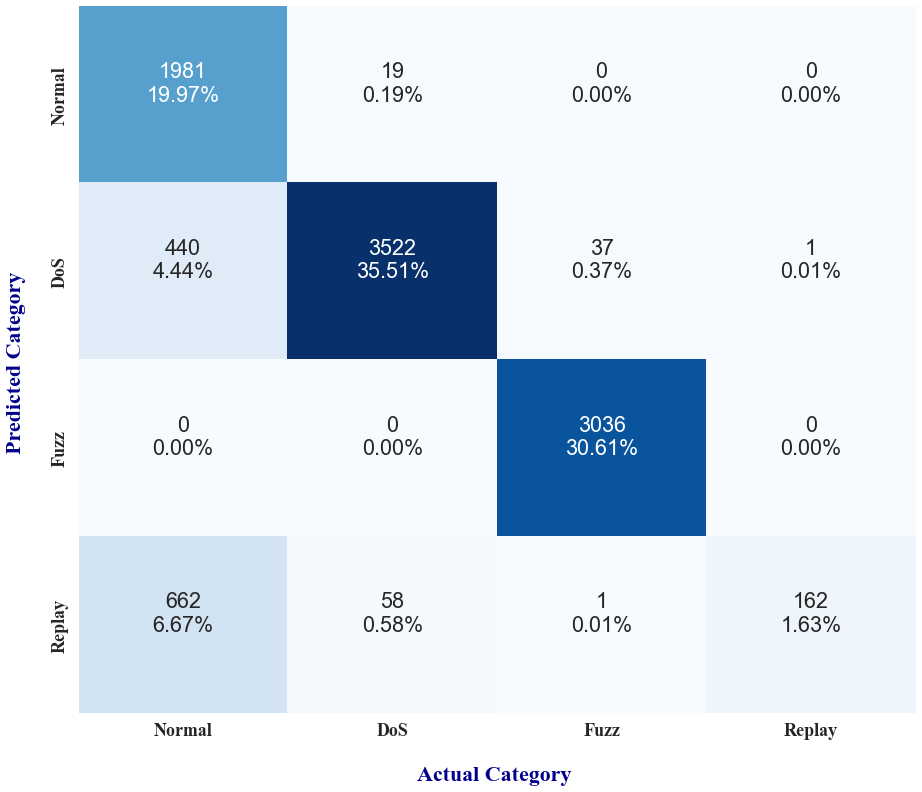

In [19]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(4,4)
sns.set(rc={'figure.figsize':(15,13)})
sns.set(font_scale=1.8) #edited as suggested
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)


ax.set_xlabel('\nActual Category ', fontname="Times New Roman", size=22,fontweight="bold")
ax.set_ylabel('Predicted Category \n', fontname="Times New Roman", size=22,fontweight="bold");
#ax.text(0.30, 4.65, Confusion Matrix CNN Multiclass Classification',fontsize=25,fontweight="bold")

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Normal", "DoS", "Fuzz", "Replay"],fontweight="bold", fontname="Times New Roman", size=18)
ax.yaxis.set_ticklabels(["Normal", "DoS", "Fuzz", "Replay"],fontweight="bold", fontname="Times New Roman", size=18)
ax.xaxis.label.set_color('darkblue')
ax.yaxis.label.set_color('darkblue')
## Display the visualization of the Confusion Matrix.
plt.show()

In [20]:
from sklearn.metrics import classification_report
class_names = ["Normal", "DoS", "Fuzz", "Replay"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.64      0.99      0.78      2000
         DoS       0.98      0.88      0.93      4000
        Fuzz       0.99      1.00      0.99      3036
      Replay       0.99      0.18      0.31       883

    accuracy                           0.88      9919
   macro avg       0.90      0.76      0.75      9919
weighted avg       0.91      0.88      0.86      9919



ROC AUC score: 0.8620832503529393


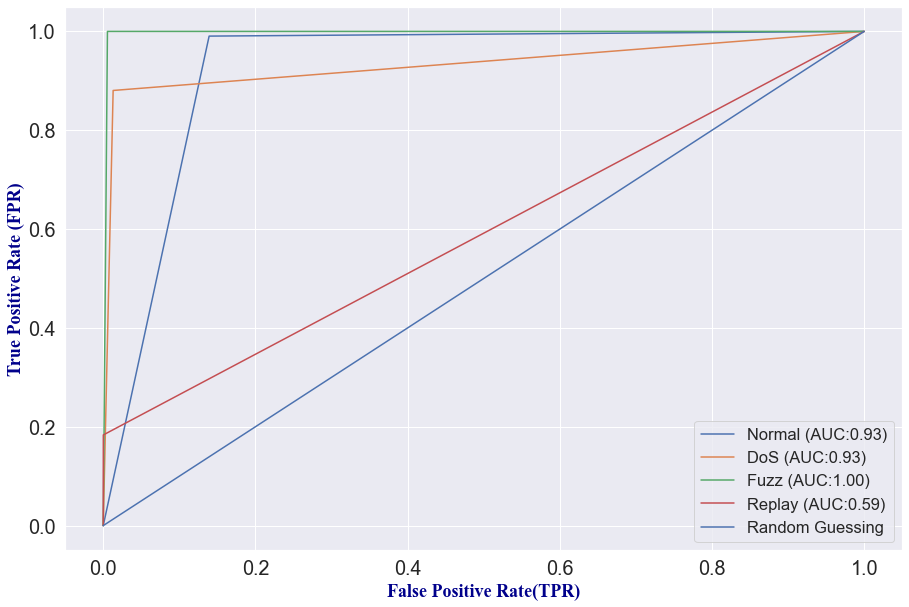

In [21]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ["Normal", "DoS", "Fuzz", "Replay"]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (15, 10))
sns.set(font_scale=1.5) #edited as suggested

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred))

c_ax.set_xlabel('False Positive Rate(TPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
c_ax.set_ylabel('True Positive Rate (FPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
#c_ax.text(0.16, -0.22, 'Fig. 6. (c) RUC Score CNN Multiclass Class Classification', fontname="Times New Roman",fontsize=25,fontweight="bold")
c_ax.legend(loc="lower right")